In [1]:
import csv
from os import listdir
from os.path import join
import os
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D,Lambda
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import csv
import numpy as np
from PIL import ImageOps
import json
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import train_test_split,cross_val_score,StratifiedKFold
from sklearn.utils import shuffle
import pandas as pd
import cv2

os.chdir("D:/Behavioral-Cloning-Project/data/data")

# CSV File and Image Path
dl_log = 'driving_log.csv'
img_path = './img'


Using TensorFlow backend.


In [2]:
from scipy.misc import imread, imresize

# cropthe image to focus on the road situation.
# remove top pixels and bottom pixels - sky and hood of the car
def preprocess(image_path):
    img = imread(image_path)
    image = img[40:-25,:,:]  
    image = imresize(image, (32,32))
    image = adj_brightness(image)
    return image

#This function Computes converts Image to HSV and a random uniform brightness 

def adj_brightness(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    random_brightness = 0.25 + np.random.uniform()
    hsv_image[:, :, 2] = hsv_image[:, :, 2] * random_brightness
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB) 



In [3]:
# Load image from file, add bias values to steer car to the center from left and right

steering_angles = []
X = []
Y = []

with open(dl_log,'r') as driving_log:
    csvreader = csv.reader(driving_log, delimiter=',')
    next(csvreader)  # This skips the first row of the CSV file.
    for row in csvreader:
        for row in csvreader:
            X.append (row[0].strip())  #  center image
            Y.append (float(row[3]))    # Steering Angles
            X.append (row[1].strip())  #  left image
            Y.append (float(row[3])+ 0.25) # Set bias values for Left-side to steer right to get back to the center. 
            X.append (row[2].strip())  #  right image
            Y.append (float(row[3]) - 0.25)   # Set bias values for right-side to steer left to get back to the center.

driving_log = pd.read_csv('driving_log.csv')
image_paths = pd.concat([driving_log['center'], driving_log['left'], driving_log['right']])                
images = [preprocess(path) for path in X]

images = np.array(images)
labels = np.array(Y)

print (images.shape) # (15385, 32, 32, 3)
print (labels.shape) # (15385,)

imgshape =(images.shape[1],images.shape[2], 3)  
print (imgshape)  # (32, 32, 3)

X, Y = (np.array(X), np.array(Y)) 

(24105, 32, 32, 3)
(24105,)
(32, 32, 3)


In [4]:
# View of driving log data
driving_log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [5]:
# Summary statistics of log data
driving_log.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002350E7B6780>]], dtype=object)

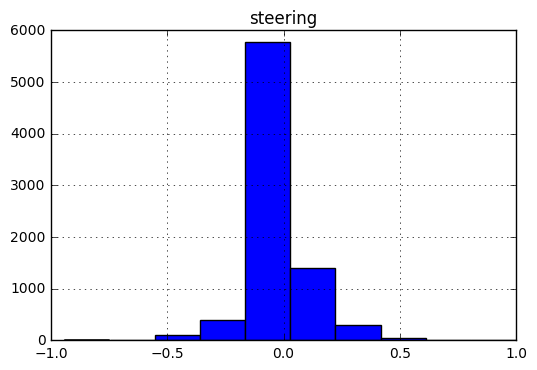

In [6]:
# Count of Steering angles by angles

%matplotlib inline
driving_log.hist(column='steering')

around ~5800 steering angles are close to zero

This image is: <class 'numpy.ndarray'> with dimesions: (160, 320, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (95, 320, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)


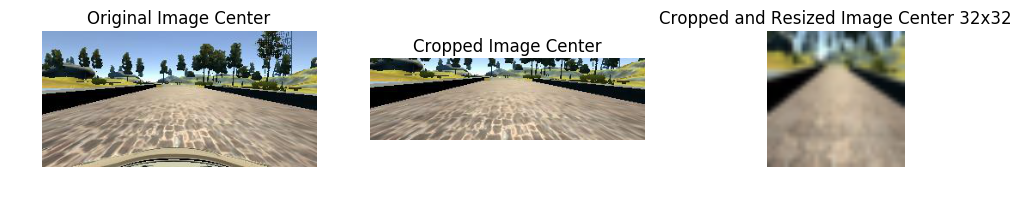

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
%matplotlib inline

fig = plt.figure(figsize=(12,6))

image = mpimg.imread('D:/Behavioral-Cloning-Project/examples/center_2016_12_01_13_30_48_287.jpg')

fig.add_subplot(3,3,1)
plt.axis('off')
plt.title("Original Image Center", fontsize=12)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

fig.add_subplot(3,3,2)
cropped_image = image[40:-25,:,:]
plt.axis('off')
plt.title("Cropped Image Center", fontsize=12)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', cropped_image.shape)
plt.imshow(cropped_image)

fig.add_subplot(3,3,3)
crop_img = image[40:-25,:,:]
image_32_32 = imresize(crop_img, (32,32))
plt.axis('off')
plt.title("Cropped and Resized Image Center 32x32", fontsize=12)
print('This image is:', type(image), 'with dimesions:', image_32_32.shape)
plt.imshow(image_32_32) 


In [8]:
# Shuffle data

from sklearn.utils import shuffle
X, y = shuffle(images, labels)

In [9]:
# Split data for train and validation testing
# Use a random seed for repoducibilty

from sklearn.cross_validation import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.15,random_state=25671)



In [10]:
# Check shapes
print (X_train.shape)
print (y_train.shape)
print (X_val.shape)
print (y_val.shape)

(20489, 32, 32, 3)
(20489,)
(3616, 32, 32, 3)
(3616,)


In [11]:
# Fucntion to flips image around the Y axis.
# Image Sample choosen from a random uniform distribution with a seed and threshold value
# for randomly transforming images with angle adjustment

def flip_img(image, angle):
    if (np.random.uniform (0, 1) > 0.5):
        image = cv2.flip(image, 1)
        angle = -1*angle
    return image, angle


# Custom Generator to draw random sample batches from the input dataset 
# and apply random flip operation for purpose of data augmentation.

def generate_train_data(X_train, y_train, batch_size=32):
    
    batch_X = np.empty((batch_size, *X_train.shape[1:]))
    batch_y = np.empty(batch_size)

    while 1:
        for batch_ in range(batch_size):
            # draw random sample from original train dataset
            idx = np.random.choice(len(X_train), batch_size)
            # randomly flip images and adjusts steering angle accordingly
            batch_X[batch_], batch_y[batch_] = flip_img( X_train[idx[batch_]], y_train[idx[batch_]])
            
        yield batch_X, batch_y


In [13]:
from keras.layers import ELU

# Define number of epochs and learning rate

nb_epoch = 50
learning_rate = 1e-5

# Build a neural network model for predicting steering angle. The actual architecture
# is based on "End to End Learning for Self-Driving Cars" paper by Nvidia.
# I have used ELU instead of ReLU because it behaves better with negative weights, so we avoid dead neurons.

 

def steering_model():
    model = Sequential()
    
    # Normalization layer : normalized between -5 and +5
    model.add( Lambda(lambda x: x/255 -.5, input_shape=imgshape)) 

    # Define 5 Conv Layers
    model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Flatten())

    # 5 fully connected layers
    model.add(Dense(1164))
    model.add(ELU())
    model.add(Dropout(.40))
    
    model.add(Dense(100))
    model.add(ELU())
    model.add(Dropout(.40))
    
    
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dropout(.40))
    
    model.add(Dense(10))
    model.add(ELU())
    model.add(Dropout(.40))
    
    model.add(Dense(1))
    
    model.summary()
    return model
    

    
#optimize using Adam optimizer and mean_squared_error loss function
model = steering_model()
model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate))

# Custom generator generate_train_data is used here

history = model.fit_generator(
    generate_train_data(X_train, y_train,32),
    samples_per_epoch= 50016, # increased number of samples here
    nb_epoch=nb_epoch,
    validation_data=(X_val, y_val))

with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)
model.save_weights('model.h5')




____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 32, 32, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 16, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 16, 16, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 15, 15, 24)    0           elu_1[0][0]                      
___________________________________________________________________________________________